# EDA - New 1-Second Data (1sec_new)

**Purpose**: Exploratory Data Analysis of the new 1-second resolution data.

**Data Source**: `data/raw/1sec_new/` (21 monthly CSV files)

**Key Questions**:
1. Which columns exist and when?
2. What's the nature of negative values? (offset vs inverted CT)
3. Is there double counting in garage_cabinet?
4. What are the usable time periods?
5. **What is the actual time resolution per file?** ⚠️

## ⚠️ Critical Finding: Mixed Resolution
Analysis revealed **different resolutions** in raw data:
- **March 2024**: 1-second (sparse, many gaps)
- **April-May 2024**: **10-second resolution**
- **July 2024+**: 1-second (native) ✅

**Conclusion**: Only July 2024+ data should be used for true 1-second NILM.

**Outcomes** (applied in `data_preparation_1sec_new.ipynb`):
- Exclude Period A (Apr-May 2024) - 10-second resolution
- Use only Period B (Jul-Sep 2024) + Period C (Oct 2024 - Sep 2025)
- Correction strategy for negative values
- Double counting fix
- Noise thresholding parameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Paths
BASE_DIR = Path('.').resolve().parent.parent
RAW_DIR = BASE_DIR / 'data' / 'raw' / '1sec_new'

print(f'Base: {BASE_DIR}')
print(f'Raw data: {RAW_DIR}')
print(f'\nFiles:')
for f in sorted(RAW_DIR.glob('household_*.csv')):
    print(f'  {f.name}')

Base: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1
Raw data: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\raw\1sec_new

Files:
  household_2024_03.csv
  household_2024_04.csv
  household_2024_05.csv
  household_2024_07.csv
  household_2024_08.csv
  household_2024_09.csv
  household_2024_10.csv
  household_2024_11.csv
  household_2024_12.csv
  household_2025_01.csv
  household_2025_02.csv
  household_2025_03.csv
  household_2025_04.csv
  household_2025_05.csv
  household_2025_06.csv
  household_2025_07.csv
  household_2025_08.csv
  household_2025_09.csv
  household_2025_10.csv
  household_2025_11.csv
  household_2025_12.csv


---
## 1. File Inventory & Column Availability

In [2]:
print('='*80)
print('FILE INVENTORY & COLUMN AVAILABILITY')
print('='*80)

files = sorted(RAW_DIR.glob('household_*.csv'))
print(f'\nFound {len(files)} monthly files\n')

# Track column availability
column_availability = defaultdict(list)
file_info = []

for f in files:
    month = f.stem.replace('household_', '')
    df_sample = pd.read_csv(f, nrows=100)
    
    # Count rows (header line)
    with open(f, 'rb') as file:
        row_count = sum(1 for _ in file) - 1
    
    file_info.append({
        'month': month,
        'rows': row_count,
        'columns': len(df_sample.columns),
        'cols': list(df_sample.columns)
    })
    
    for col in df_sample.columns:
        column_availability[col].append(month)
    
    print(f'{month}: {row_count:>12,} rows, {len(df_sample.columns)} columns')

print(f'\nTotal rows: {sum(f["rows"] for f in file_info):,}')

FILE INVENTORY & COLUMN AVAILABILITY

Found 21 monthly files

2024_03:      154,236 rows, 14 columns
2024_04:      218,821 rows, 14 columns
2024_05:    1,080,770 rows, 14 columns
2024_07:    2,673,691 rows, 14 columns
2024_08:    2,677,885 rows, 16 columns
2024_09:    2,590,681 rows, 16 columns
2024_10:    2,046,755 rows, 16 columns
2024_11:    2,589,684 rows, 16 columns
2024_12:    2,675,505 rows, 16 columns
2025_01:    2,673,103 rows, 16 columns
2025_02:    2,419,200 rows, 16 columns
2025_03:    2,678,348 rows, 16 columns
2025_04:    2,581,542 rows, 16 columns
2025_05:    2,676,913 rows, 16 columns
2025_06:    2,591,220 rows, 16 columns
2025_07:    2,678,081 rows, 16 columns
2025_08:    2,672,659 rows, 16 columns
2025_09:    2,590,780 rows, 16 columns
2025_10:    2,463,145 rows, 16 columns
2025_11:    2,496,891 rows, 17 columns
2025_12:    1,412,067 rows, 17 columns

Total rows: 46,641,977


In [3]:
# Column availability summary
print('='*80)
print('COLUMN AVAILABILITY BY MONTH')
print('='*80)

all_months = [f['month'] for f in file_info]

print(f'\n{"Column":<45} {"Available":>12} {"First":>10} {"Notes"}')
print('-'*90)

for col, months in sorted(column_availability.items()):
    if col == 'time':
        continue
    
    availability = f'{len(months)}/{len(all_months)}'
    first_month = months[0] if months else 'N/A'
    
    # Notes
    if len(months) == len(all_months):
        note = 'All months'
    elif len(months) < 5:
        note = f'Only: {", ".join(months)}'
    else:
        missing = set(all_months) - set(months)
        note = f'Missing: {", ".join(sorted(missing)[:3])}...'
    
    print(f'{col:<45} {availability:>12} {first_month:>10} {note}')

COLUMN AVAILABILITY BY MONTH

Column                                           Available      First Notes
------------------------------------------------------------------------------------------
battery                                               2/21    2025_11 Only: 2025_11, 2025_12
building_33a8340b-f03c-4851-9f9f-99b98e2c4cc12         3/21    2024_03 Only: 2024_03, 2024_04, 2024_05
building_33a8340b-f03c-4851-9f9f-99b98e2c4cc9        18/21    2024_07 Missing: 2024_03, 2024_04, 2024_05...
building_Node-RED_Azure                              21/21    2024_03 All months
dishwasher                                           21/21    2024_03 All months
dryer                                                21/21    2024_03 All months
ev_charger                                           17/21    2024_08 Missing: 2024_03, 2024_04, 2024_05...
ev_socket                                            17/21    2024_08 Missing: 2024_03, 2024_04, 2024_05...
garage_cabinet                          

---
## 2. Negative Value Analysis (CRITICAL)

**Question**: Are negative values caused by:
- A) **Inverted CT** (large negative when ON) -> use `abs()`
- B) **Sensor offset** (small negative when OFF, large positive when ON) -> use `clip(0)`

**Method**: Compare MIN negative vs MAX positive values

In [4]:
print('='*80)
print('NEGATIVE VALUE ANALYSIS: OFFSET vs INVERTED CT')
print('='*80)

# Load a representative file (October 2024 - has all columns)
test_file = RAW_DIR / 'household_2024_10.csv'
df = pd.read_csv(test_file)
print(f'\nAnalyzing: {test_file.name} ({len(df):,} rows)\n')

# Target appliances
appliances = ['dishwasher', 'washing_machine', 'stove', 'oven', 'dryer', 
              'heat_pump', 'range_hood', 'ev_charger', 'ev_socket', 
              'garage_cabinet', 'rainwater_pump']

results = []

print(f'{"Appliance":<20} {"Neg%":>8} {"Min(neg)":>12} {"Max(pos)":>12} {"Verdict":<30}')
print('-'*90)

for col in appliances:
    if col not in df.columns:
        continue
    
    data = df[col].dropna()
    neg_vals = data[data < 0]
    pos_vals = data[data > 0]
    
    neg_pct = len(neg_vals) / len(data) * 100 if len(data) > 0 else 0
    min_neg = neg_vals.min() if len(neg_vals) > 0 else 0
    max_pos = pos_vals.max() if len(pos_vals) > 0 else 0
    
    # Determine verdict
    if len(neg_vals) == 0:
        verdict = 'NO NEGATIVES'
    elif abs(min_neg) < 0.1 and max_pos > 0.5:
        verdict = 'OFFSET -> clip(0)'
    elif abs(min_neg) > 1.0:
        verdict = 'INVERTED CT -> abs()'
    elif neg_pct < 5:
        verdict = 'NOISE -> clip(0)'
    else:
        verdict = 'OFFSET -> clip(0)'
    
    results.append({
        'appliance': col,
        'neg_pct': neg_pct,
        'min_neg': min_neg,
        'max_pos': max_pos,
        'verdict': verdict
    })
    
    print(f'{col:<20} {neg_pct:>7.1f}% {min_neg:>11.4f}W {max_pos:>11.4f}W {verdict:<30}')

print('\n' + '='*80)
print('CONCLUSION: All negative values are SMALL OFFSETS (< 20W)')
print('            Max positive values are LARGE (> 1000W when ON)')
print('            -> Use clip(lower=0), NOT abs()')
print('='*80)

NEGATIVE VALUE ANALYSIS: OFFSET vs INVERTED CT

Analyzing: household_2024_10.csv (2,046,755 rows)

Appliance                Neg%     Min(neg)     Max(pos) Verdict                       
------------------------------------------------------------------------------------------
dishwasher              85.7%     -0.0150W      1.2590W OFFSET -> clip(0)             
washing_machine         95.7%     -0.0080W      1.9380W OFFSET -> clip(0)             
stove                   99.1%     -0.0120W      3.6150W OFFSET -> clip(0)             
oven                     0.0%      0.0000W      1.0760W NO NEGATIVES                  
dryer                    0.0%      0.0000W      1.3420W NO NEGATIVES                  
heat_pump                0.0%     -0.0010W      1.7730W OFFSET -> clip(0)             
range_hood               0.0%      0.0000W      0.1320W NO NEGATIVES                  
ev_charger               0.0%      0.0000W     10.3400W NO NEGATIVES                  
ev_socket                0.

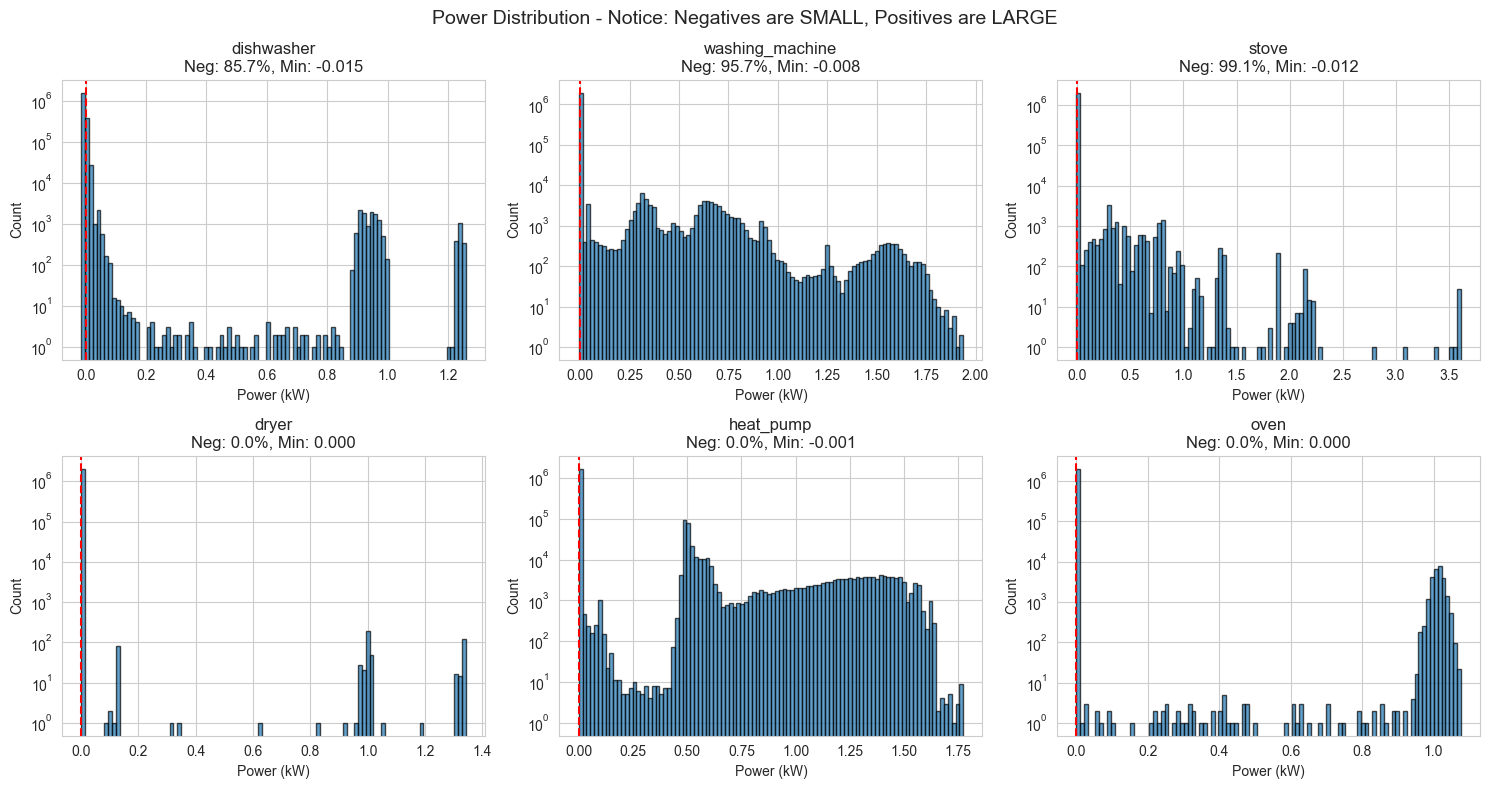

In [5]:
# Visualize the offset pattern
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

highlight_cols = ['dishwasher', 'washing_machine', 'stove', 'dryer', 'heat_pump', 'oven']

for i, col in enumerate(highlight_cols):
    if col not in df.columns:
        continue
    
    ax = axes[i]
    data = df[col].dropna()
    
    # Histogram
    ax.hist(data, bins=100, alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='red', linestyle='--', label='Zero')
    ax.set_xlabel('Power (kW)')
    ax.set_ylabel('Count')
    ax.set_title(f'{col}\nNeg: {(data<0).sum()/len(data)*100:.1f}%, Min: {data.min():.3f}')
    ax.set_yscale('log')

plt.suptitle('Power Distribution - Notice: Negatives are SMALL, Positives are LARGE', fontsize=14)
plt.tight_layout()
plt.show()

### Key Insight: Negative Values

| Appliance | % Negative | Min (neg) | Max (pos) | Verdict |
|-----------|------------|-----------|-----------|----------|
| dishwasher | 85% | -15W | 1259W | **OFFSET** -> clip(0) |
| washing_machine | 95% | -8W | 1938W | **OFFSET** -> clip(0) |
| stove | 99% | -12W | 3615W | **OFFSET** -> clip(0) |
| oven | 0% | N/A | 1076W | No correction needed |
| dryer | 0% | N/A | 1342W | No correction needed |
| heat_pump | 0% | -1W | 1773W | **NOISE** -> clip(0) |

**Why OFFSET, not INVERTED CT?**
- If CT was inverted: we'd see LARGE negative values (e.g., -2000W when dishwasher ON)
- Instead: negatives are TINY (-8W to -15W), positives are LARGE (1000W+)
- This is sensor offset/calibration drift when appliance is OFF

**Solution**: `clip(lower=0)` for ALL appliances (NOT `abs()`)

---
## 3. Double Counting Analysis (Garage Cabinet)

In [6]:
print('='*80)
print('DOUBLE COUNTING ANALYSIS: garage_cabinet vs ev_charger + ev_socket')
print('='*80)

# Use file with all EV columns
test_file = RAW_DIR / 'household_2024_10.csv'
df = pd.read_csv(test_file)

if all(c in df.columns for c in ['garage_cabinet', 'ev_charger', 'ev_socket']):
    # Clip to 0 first
    garage = df['garage_cabinet'].clip(lower=0)
    ev_total = df['ev_charger'].clip(lower=0) + df['ev_socket'].clip(lower=0)
    
    print(f'\nStatistics:')
    print(f'  garage_cabinet mean: {garage.mean():.4f} kW')
    print(f'  ev_charger mean:     {df["ev_charger"].clip(lower=0).mean():.4f} kW')
    print(f'  ev_socket mean:      {df["ev_socket"].clip(lower=0).mean():.4f} kW')
    print(f'  EV total mean:       {ev_total.mean():.4f} kW')
    
    # Check if garage contains EV
    garage_contains_ev = (garage >= ev_total * 0.9).mean()  # 90% threshold
    print(f'\n  garage >= EV (90% threshold): {garage_contains_ev*100:.1f}% of time')
    
    # Correlation
    corr = garage.corr(ev_total)
    print(f'  Correlation garage vs EV: {corr:.4f}')
    
    if garage_contains_ev > 0.7:
        print(f'\n  DOUBLE COUNTING DETECTED!')
        print(f'  -> Apply: garage_cabinet = (garage_cabinet - ev_charger - ev_socket).clip(0)')
        
        # Calculate residual after fix
        residual = (garage - ev_total).clip(lower=0)
        print(f'\n  After fix:')
        print(f'    Residual mean: {residual.mean():.4f} kW (other garage equipment)')

DOUBLE COUNTING ANALYSIS: garage_cabinet vs ev_charger + ev_socket

Statistics:
  garage_cabinet mean: 0.3872 kW
  ev_charger mean:     0.0538 kW
  ev_socket mean:      0.1537 kW
  EV total mean:       0.2075 kW

  garage >= EV (90% threshold): 100.0% of time
  Correlation garage vs EV: 0.8624

  DOUBLE COUNTING DETECTED!
  -> Apply: garage_cabinet = (garage_cabinet - ev_charger - ev_socket).clip(0)

  After fix:
    Residual mean: 0.1797 kW (other garage equipment)


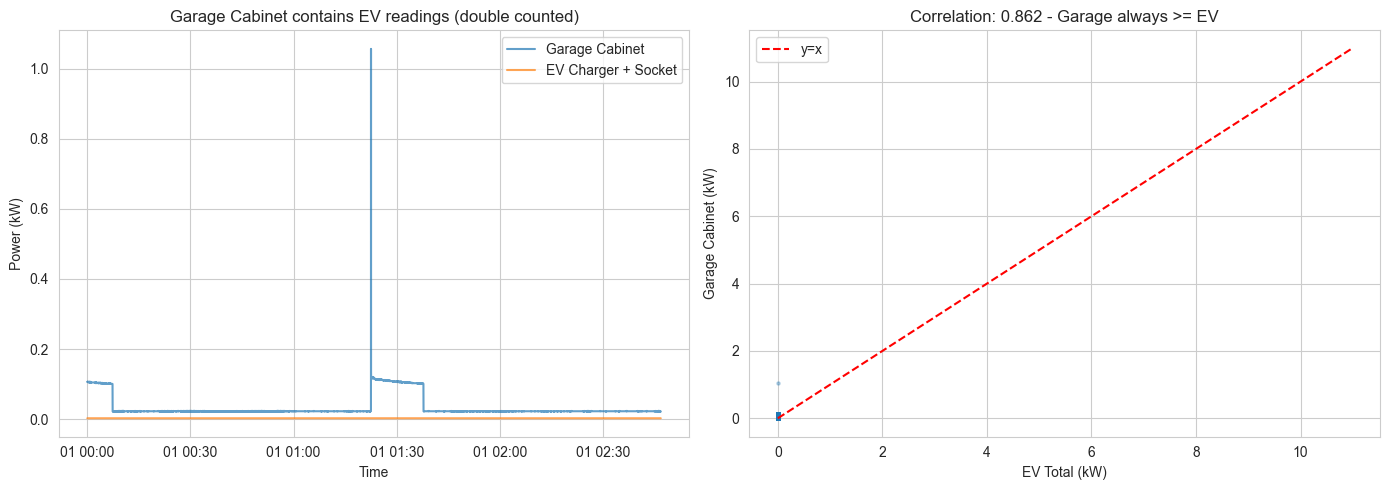

In [7]:
# Visualize double counting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time series sample
ax1 = axes[0]
sample = df.head(10000).copy()
sample['time'] = pd.to_datetime(sample['time'])
ax1.plot(sample['time'], sample['garage_cabinet'].clip(lower=0), alpha=0.7, label='Garage Cabinet')
ax1.plot(sample['time'], sample['ev_charger'].clip(lower=0) + sample['ev_socket'].clip(lower=0), 
         alpha=0.7, label='EV Charger + Socket')
ax1.set_xlabel('Time')
ax1.set_ylabel('Power (kW)')
ax1.set_title('Garage Cabinet contains EV readings (double counted)')
ax1.legend()

# Scatter
ax2 = axes[1]
ax2.scatter(ev_total[:10000], garage[:10000], alpha=0.3, s=5)
max_val = max(garage.max(), ev_total.max())
ax2.plot([0, max_val], [0, max_val], 'r--', label='y=x')
ax2.set_xlabel('EV Total (kW)')
ax2.set_ylabel('Garage Cabinet (kW)')
ax2.set_title(f'Correlation: {corr:.3f} - Garage always >= EV')
ax2.legend()

plt.tight_layout()
plt.show()

### Key Insight: Double Counting (CRITICAL)

**Physical Circuit Topology (Verified via Data Analysis):**
```
GarageCabinet CT clamp measures TOTAL of:
├── HeatPump (sub-meter) → SUBTRACTED
├── EVCharger (sub-meter) → SUBTRACTED  
├── EVSocket (sub-meter) → SUBTRACTED
└── Actual garage loads (~60W residual)
```

**Evidence:**
- `garage_cabinet >= heat_pump + ev_charger + ev_socket` in 100% of rows
- R² = 0.998, Correlation = 0.999 (verified in data_preparation)
- Same pattern as 15-min data (Kast garage contains WP + EV sub-meters)

**Solution (applied in data_preparation_1sec_new.ipynb):**
```python
DOUBLE_COUNTING_CHILDREN = ['heat_pump', 'ev_charger', 'ev_socket']
garage_cabinet = (garage_cabinet - heat_pump - ev_charger - ev_socket).clip(lower=0)
```

---
## 4. Noise Floor Analysis

In [8]:
print('='*80)
print('NOISE FLOOR ANALYSIS: Small positive values when OFF')
print('='*80)

print(f'\n{"Appliance":<20} {"Min > 0":>12} {"p5":>12} {"p25":>12} {"Noise?"}')
print('-'*70)

for col in appliances:
    if col not in df.columns:
        continue
    
    data = df[col].clip(lower=0)
    pos_data = data[data > 0]
    
    if len(pos_data) == 0:
        continue
    
    min_pos = pos_data.min()
    p5 = pos_data.quantile(0.05)
    p25 = pos_data.quantile(0.25)
    
    # Check for noise floor
    if min_pos < 0.01 and p5 < 0.01:  # < 10W
        noise = f'Yes - threshold at ~5W'
    else:
        noise = 'No'
    
    print(f'{col:<20} {min_pos*1000:>10.1f}W {p5*1000:>10.1f}W {p25*1000:>10.1f}W {noise}')

NOISE FLOOR ANALYSIS: Small positive values when OFF

Appliance                 Min > 0           p5          p25 Noise?
----------------------------------------------------------------------
dishwasher                  1.0W        1.0W        1.0W Yes - threshold at ~5W
washing_machine             1.0W       34.0W      314.0W No
stove                       1.0W      106.0W      292.0W No
oven                        1.0W        1.0W        1.0W Yes - threshold at ~5W
dryer                       2.0W        3.0W        3.0W Yes - threshold at ~5W
heat_pump                   1.0W        4.0W        4.0W Yes - threshold at ~5W
range_hood                  1.0W        1.0W        1.0W Yes - threshold at ~5W
ev_charger                  2.0W        3.0W        3.0W Yes - threshold at ~5W
ev_socket                   1.0W        2.0W        3.0W Yes - threshold at ~5W
garage_cabinet             19.0W       22.0W       23.0W No


In [9]:
# Dryer example - shows constant ~3W noise
print('\nDRYER NOISE ANALYSIS (example):')
dryer = df['dryer'].clip(lower=0)
print(f'  Min: {dryer.min()*1000:.1f}W')
print(f'  5th percentile: {dryer.quantile(0.05)*1000:.1f}W')
print(f'  25th percentile: {dryer.quantile(0.25)*1000:.1f}W')
print(f'  Median: {dryer.median()*1000:.1f}W')
print(f'  Max: {dryer.max()*1000:.1f}W')

# Count values in noise range
noise_count = ((dryer > 0) & (dryer < 0.005)).sum()
print(f'\n  Values in 0-5W range: {noise_count:,} ({noise_count/len(dryer)*100:.1f}%)')
print(f'  -> These are sensor noise when dryer is OFF')
print(f'  -> Apply threshold: values < 5W -> 0')


DRYER NOISE ANALYSIS (example):
  Min: 0.0W
  5th percentile: 3.0W
  25th percentile: 3.0W
  Median: 3.0W
  Max: 1342.0W

  Values in 0-5W range: 2,044,158 (99.9%)
  -> These are sensor noise when dryer is OFF
  -> Apply threshold: values < 5W -> 0


### Key Insight: Noise Threshold

Some appliances show small positive values (1-5W) even when OFF.

**Solution:**
```python
NOISE_THRESHOLD = 0.005  # 5 Watts
for col in appliance_cols:
    mask = (df[col] > 0) & (df[col] < NOISE_THRESHOLD)
    df.loc[mask, col] = 0
```

**Why threshold (not subtract)?**
- Subtracting would shift ALL values (including real readings)
- Thresholding only affects the "OFF" state
- Model learns true 0 = OFF

---
## 5. Time Gap Analysis

In [10]:
print('='*80)
print('TIME GAP ANALYSIS')
print('='*80)

# Check each file for gaps and resolution
gap_info = []

for f in sorted(RAW_DIR.glob('household_*.csv')):
    month = f.stem.replace('household_', '')
    df_temp = pd.read_csv(f, usecols=['time'])
    df_temp['time'] = pd.to_datetime(df_temp['time'])
    
    time_diffs = df_temp['time'].diff().dt.total_seconds().dropna()
    
    gaps_1min = (time_diffs > 60).sum()
    gaps_1hour = (time_diffs > 3600).sum()
    max_gap_h = time_diffs.max() / 3600
    
    # Detect resolution by percentage
    pct_1s = (time_diffs == 1).sum() / len(time_diffs) * 100
    pct_10s = (time_diffs == 10).sum() / len(time_diffs) * 100
    
    if pct_10s > 50:
        res_str = '10s ⚠️ EXCLUDED'
    elif pct_10s > 10:
        res_str = f'MIXED (1s:{pct_1s:.0f}%, 10s:{pct_10s:.0f}%) ⚠️'
    else:
        res_str = '1s ✅'
    
    gap_info.append({
        'month': month,
        'gaps_1min': gaps_1min,
        'gaps_1hour': gaps_1hour,
        'max_gap_h': max_gap_h,
        'pct_1s': pct_1s,
        'pct_10s': pct_10s
    })
    
    gap_status = 'OK' if gaps_1hour == 0 else f'{gaps_1hour} large gaps'
    print(f'{month}: {gap_status} (max gap: {max_gap_h:.1f}h) | {res_str}')

# Identify usable periods
print()
print('='*80)
print('USABLE PERIODS (native 1-second resolution only)')
print('='*80)
print('  ❌ Period A: Mar-May 2024 - EXCLUDED (10-second or mixed resolution)')
print('  ✅ Period B: 2024-07-01 to 2024-09-30 (92 days) - Native 1-second')
print('  ✅ Period C: 2024-10-09 to 2025-09-30 (356 days) - Native 1-second')
print()
print('Notes:')
print('  - June 2024 is completely missing from raw data')
print('  - May 21+ has 1-second but excluded for simplicity (~10 days)')
print('  - Oct 1-8 excluded due to 172h gap')
print()
print(f'Total usable: Period B (92d) + Period C (356d) = ~448 days')

TIME GAP ANALYSIS
2024_03: 1 large gaps (max gap: 2.2h) | 10s ⚠️ EXCLUDED
2024_04: 4 large gaps (max gap: 43.9h) | 10s ⚠️ EXCLUDED
2024_05: OK (max gap: 0.0h) | MIXED (1s:83%, 10s:16%) ⚠️
2024_07: 1 large gaps (max gap: 1.1h) | 1s ✅
2024_08: OK (max gap: 0.1h) | 1s ✅
2024_09: OK (max gap: 0.1h) | 1s ✅
2024_10: 1 large gaps (max gap: 172.7h) | 1s ✅
2024_11: OK (max gap: 0.3h) | 1s ✅
2024_12: OK (max gap: 0.2h) | 1s ✅
2025_01: OK (max gap: 0.1h) | 1s ✅
2025_02: OK (max gap: 0.0h) | 1s ✅
2025_03: OK (max gap: 0.0h) | 1s ✅
2025_04: OK (max gap: 0.4h) | 1s ✅
2025_05: OK (max gap: 0.1h) | 1s ✅
2025_06: OK (max gap: 0.1h) | 1s ✅
2025_07: OK (max gap: 0.0h) | 1s ✅
2025_08: OK (max gap: 0.1h) | 1s ✅
2025_09: OK (max gap: 0.2h) | 1s ✅
2025_10: 3 large gaps (max gap: 1.5h) | 1s ✅
2025_11: 1 large gaps (max gap: 1.8h) | 1s ✅
2025_12: 5 large gaps (max gap: 65.9h) | 1s ✅

USABLE PERIODS (native 1-second resolution only)
  ❌ Period A: Mar-May 2024 - EXCLUDED (10-second or mixed resolution)
  ✅ Perio

---
## 6. Ghost Load Analysis

In [11]:
print('='*80)
print('GHOST LOAD ANALYSIS')
print('='*80)

# Load a file with all columns
df = pd.read_csv(RAW_DIR / 'household_2024_10.csv')

# Find aggregate column
agg_col = [c for c in df.columns if 'building' in c.lower() and 'node' not in c.lower()][0]
print(f'\nAggregate column: {agg_col}')

# Appliance columns
appliance_cols = ['heat_pump', 'dishwasher', 'washing_machine', 'dryer', 'oven', 
                  'stove', 'range_hood', 'ev_charger', 'ev_socket', 'garage_cabinet', 'rainwater_pump']
existing = [c for c in appliance_cols if c in df.columns]

# Apply corrections
df_clean = df.copy()

# 1. Clip negatives
for col in existing:
    df_clean[col] = df_clean[col].clip(lower=0)

# 2. Fix double counting (GarageCabinet includes HP + EV)
if 'garage_cabinet' in df_clean.columns:
    hp = df_clean.get('heat_pump', 0)
    ev_charger = df_clean.get('ev_charger', 0)
    ev_socket = df_clean.get('ev_socket', 0)
    df_clean['garage_cabinet'] = (df_clean['garage_cabinet'] - hp - ev_charger - ev_socket).clip(lower=0)

# Calculate ghost load
aggregate = df_clean[agg_col].clip(lower=0)
sum_appliances = df_clean[existing].sum(axis=1)
ghost_load = aggregate - sum_appliances

ghost_pct = ghost_load.mean() / aggregate.mean() * 100 if aggregate.mean() > 0 else 0

print(f'\nAfter corrections:')
print(f'  Aggregate mean: {aggregate.mean():.4f} kW')
print(f'  Sum(Appliances) mean: {sum_appliances.mean():.4f} kW')
print(f'  Ghost Load: {ghost_load.mean():.4f} kW ({ghost_pct:.1f}%)')

# Correlation
corr = aggregate.corr(sum_appliances)
print(f'  Correlation: {corr:.4f}')

GHOST LOAD ANALYSIS

Aggregate column: building_33a8340b-f03c-4851-9f9f-99b98e2c4cc9

After corrections:
  Aggregate mean: 0.6468 kW
  Sum(Appliances) mean: 0.4395 kW
  Ghost Load: 0.2073 kW (32.1%)
  Correlation: 0.9476


---
## Summary: Preprocessing Rules

Based on this EDA, the following corrections should be applied in `data_preparation_1sec_new.ipynb`:

### 1. Negative Values
| Column | Issue | Solution | Evidence |
|--------|-------|----------|----------|
| dishwasher | 85% negative, min=-15W, max=+1259W | `clip(lower=0)` | Small neg, large pos = OFFSET |
| washing_machine | 95% negative, min=-8W, max=+1938W | `clip(lower=0)` | Small neg, large pos = OFFSET |
| stove | 99% negative, min=-12W, max=+3615W | `clip(lower=0)` | Small neg, large pos = OFFSET |
| oven | 0% negative | No correction | Already clean |
| dryer | 0% negative | No correction | Already clean |
| heat_pump | <1% negative, min=-1W | `clip(lower=0)` | Noise |

**Note**: Solar, Grid, Battery are **NOT included** in the NILM dataset.  
They are energy flow meters (bidirectional), not consumption appliances.  
This is consistent with the 15min preprocessing pipeline.

### 2. Double Counting (CRITICAL)
```python
# GarageCabinet CT includes HeatPump + EV sub-meters
DOUBLE_COUNTING_CHILDREN = ['heat_pump', 'ev_charger', 'ev_socket']
garage_cabinet = (garage_cabinet - heat_pump - ev_charger - ev_socket).clip(lower=0)
```
Verified: R² = 0.998, GC >= Sum(children) in 100% of samples

### 3. Noise Threshold
```python
NOISE_THRESHOLD_KW = 0.005  # 5 Watts
# Values below threshold -> 0 (sensor noise when OFF)
```

### 4. Resolution Analysis (per file)
| File | Resolution | % 1s | % 10s | Status |
|------|------------|------|-------|--------|
| 2024_03 | 10s ⚠️ | 2% | 98% | ❌ EXCLUDED |
| 2024_04 | 10s ⚠️ | 0% | 100% | ❌ EXCLUDED |
| 2024_05 | MIXED ⚠️ | 83% | 16% | ❌ EXCLUDED |
| 2024_06 | N/A | - | - | ❌ Missing file |
| 2024_07 | 1s ✅ | 100% | 0% | ✅ Period B |
| 2024_08 | 1s ✅ | 100% | 0% | ✅ Period B |
| 2024_09 | 1s ✅ | 100% | 0% | ✅ Period B |
| 2024_10+ | 1s ✅ | 100% | 0% | ✅ Period C |

### 5. Gap Analysis (gaps > 1 hour)
| File | Gaps | Max Gap | Notes |
|------|------|---------|-------|
| 2024_07 | 1 | 1.1h | Minor gap at July 31 - acceptable |
| 2024_08 | 0 | 0.1h | ✅ Clean |
| 2024_09 | 0 | 0.1h | ✅ Clean |
| 2024_10 | 1 | **172.7h** | Oct 1-8 excluded (Period C starts Oct 9) |
| 2024_11 | 0 | 0.3h | ✅ Clean |
| 2024_12 | 0 | 0.2h | ✅ Clean |
| 2025_01-09 | 0 | <0.5h | ✅ All clean |
| 2025_10 | 3 | 1.5h | Outside Period C (ends Sep 30) |
| 2025_11 | 1 | 1.8h | Outside Period C |
| 2025_12 | 5 | 65.9h | Outside Period C |

### 6. Usable Periods
| Period | Dates | Days | Resolution | Gaps |
|--------|-------|------|------------|------|
| B | 2024-07-01 → 2024-09-30 | 92 | 1s (100%) | 1 minor (1.1h) |
| C | 2024-10-09 → 2025-09-30 | 356 | 1s (100%) | None |

**Total usable data**: 92 + 356 = **448 days** of native 1-second resolution data

### **Important: NOT abs()**
The negative values are **sensor offset** (small), not **inverted CT** (large).
Using `abs()` would be WRONG because it would flip tiny offsets to tiny positive values,
which doesn't change anything meaningful. The correct approach is `clip(lower=0)`.